In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#if required to remove
#!rm -rf /content/sd_GSCmdV2

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5938370460528613087
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11154422528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10075279467294305503
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
%tensorflow_version 2.x
#upload requirements file
!pip install -r /content/drive/MyDrive/SamsungPrismVMAR/requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for kapre: filename=kapre-0.2.0-cp37-none-any.whl size=12318 sha256=84e5042022027062abf4e11c1fd2fbff9accbd1e0e025e517084ad0c62ae9fe7
  Stored in directory: /root/.cache/pip/wheels/ae/ad/ed/64d0aa7880141295cb3449348cc2a5970c292a2de99c70e122
Successfully built kapre
  Found existing installation: kapre 0.1.3.1
    Uninstalling kapre-0.1.3.1:
      Successfully uninstalled kapre-0.1.3.1


In [4]:
import os
os.makedirs("sd_GSCmdV2/")
!unzip /content/drive/MyDrive/SamsungPrismVMAR/SpeechCmd_numpy.zip -d /

Streaming output truncated to the last 5000 lines.
  inflating: /content/sd_GSCmdV2/train/six/f292725f_nohash_1.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/5cf1ecce_nohash_3.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/65c73b55_nohash_0.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/ce0cb033_nohash_3.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/bbf38549_nohash_4.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/7f9eb952_nohash_2.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/a7acbbeb_nohash_0.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/8134f43f_nohash_4.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/1b63157b_nohash_0.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/71f6fed7_nohash_0.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/151bfb79_nohash_0.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/099d52ad_nohash_3.wav.npy  
  inflating: /content/sd_GSCmdV2/train/six/30060aba_nohash_0.wav.npy  
  inflating: /content/sd_G

In [5]:
import tensorflow as tf
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from tqdm import tqdm
import requests
import math
import os
import tarfile
import numpy as np
import librosa
import pandas as pd
import itertools
import kapre

In [6]:
def Convert_to_numpy(folder, sr=None):
    allFiles = []
    for root, dirs, files in os.walk(folder):
        allFiles += [os.path.join(root, f) for f in files
                     if f.endswith('.wav')]

    for file in tqdm(allFiles):
        y, sr = librosa.load(file, sr=None)
        np.save(file + '.npy', y)
        os.remove(file)


def speech_setup( forceDownload=False):
    _speechdownload(forceDownload)
    num_catgs = 36
    basePath = 'sd_GSCmdV2'
    cat_dictionary = {'unknown': 0,'silence': 0,'_unknown_': 0,'_silence_': 0,'_background_noise_': 0,'nine': 1,
                      'yes': 2,'no': 3,'up': 4,'down': 5,'left': 6,'right': 7,'on': 8,'off': 9,'stop': 10,'go': 11,'zero': 12,'one': 13,'two': 14,'three': 15,
                      'four': 16,'five': 17,'six': 18,'seven': 19,'eight': 20,'backward': 21,'bed': 22,'bird': 23,'cat': 24,'dog': 25,'follow': 26,'forward': 27,
                      'happy': 28,'house': 29,'learn': 30,'marvin': 31,'sheila': 32,'tree': 33,'visual': 34,'wow': 35}    

    Convert_to_numpy(basePath + '/test/')
    Convert_to_numpy(basePath + '/train/')

    # read split from files and all files in folders
    testWAVs = pd.read_csv(basePath + '/train/testing_list.txt', sep=" ", header=None)[0].tolist()
    valWAVs = pd.read_csv(basePath + '/train/validation_list.txt', sep=" ", header=None)[0].tolist()

    testWAVs = [os.path.join(basePath + '/train/', f + '.npy')for f in testWAVs if f.endswith('.wav')]
    valWAVs = [os.path.join(basePath + '/train/', f + '.npy') for f in valWAVs if f.endswith('.wav')]

    allWAVs = []

    for root, dirs, files in os.walk(basePath + '/train/'):
        allWAVs += [root + '/' + f for f in files if f.endswith('.wav.npy')]
    trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

    testWAVsREAL = []
    for root, dirs, files in os.walk(basePath + '/test/'):
        testWAVsREAL += [root + '/' + f for f in files if f.endswith('.wav.npy')]

    # get categories
    testWAVlabels = [get_label(f, cat_dictionary) for f in testWAVs]
    valWAVlabels = [get_label(f, cat_dictionary) for f in valWAVs]
    trainWAVlabels = [get_label(f, cat_dictionary) for f in trainWAVs]
    testWAVREALlabels = [get_label(f, cat_dictionary) for f in testWAVsREAL]

    # background noise should be used for validation as well
    backNoiseFiles = [trainWAVs[i] for i in range(len(trainWAVlabels))
                  if trainWAVlabels[i] == cat_dictionary['silence']]
    backNoiseCats = [cat_dictionary['silence']
                 for i in range(len(backNoiseFiles))]

     # build dictionaries
    testWAVlabelsDict = dict(zip(testWAVs, testWAVlabels))
    valWAVlabelsDict = dict(zip(valWAVs, valWAVlabels))
    trainWAVlabelsDict = dict(zip(trainWAVs, trainWAVlabels))
    testWAVREALlabelsDict = dict(zip(testWAVsREAL, testWAVREALlabels))

        

    # info dictionary
    trainInfo = {'files': trainWAVs, 'labels': trainWAVlabelsDict}
    valInfo = {'files': valWAVs, 'labels': valWAVlabelsDict}
    testInfo = {'files': testWAVs, 'labels': testWAVlabelsDict}
    testREALInfo = {'files': testWAVsREAL, 'labels': testWAVREALlabelsDict}
    cmd_file = {'train': trainInfo,
               'test': testInfo,
               'val': valInfo,
               'testREAL': testREALInfo}

    print('Dataset prepared...!!')

    return cmd_file, num_catgs


def get_label(file, cat_dictionary):
    categ = os.path.basename(os.path.dirname(file))
    return cat_dictionary.get(categ, 0)


def _speechdownload(forceDownload=False):
  
    if os.path.isdir("sd_GSCmdV2/") and not forceDownload:
        print('File exists')
    else:
        if not os.path.exists("sd_GSCmdV2/"):
            os.makedirs("sd_GSCmdV2/")
        trainFiles = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
        testFiles = 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'
        _download(testFiles, 'sd_GSCmdV2/test.tar.gz')
        _download(trainFiles, 'sd_GSCmdV2/train.tar.gz')

    # extract files
    if not os.path.isdir("sd_GSCmdV2/test/"):
        _extractTar('sd_GSCmdV2/test.tar.gz', 'sd_GSCmdV2/test/')

    if not os.path.isdir("sd_GSCmdV2/train/"):
        _extractTar('sd_GSCmdV2/train.tar.gz', 'sd_GSCmdV2/train/')


def _download(url, fName):
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024
    wrote = 0
    print('Downloading {} into {}'.format(url, fName))
    with open(fName, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=math.ceil(total_size // block_size),
                         unit='KB',
                         unit_scale=True):
            wrote = wrote + len(data)
            f.write(data)
    if total_size != 0 and wrote != total_size:
        print("Download failed")


def _extractTar(fname, folder):
    print('Extracting {} into {}'.format(fname, folder))
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=folder)
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall(path=folder)
        tar.close()


In [7]:
cmd_file, num_catgs = speech_setup() 
print(cmd_file.keys())
print(cmd_file['train'].keys())
print(len(cmd_file['train']['files']))
print(num_catgs)

0it [00:00, ?it/s]
0it [00:00, ?it/s]

File exists


Dataset prepared...!!
dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


In [8]:
import numpy as np
import tensorflow.keras


class SpeechGen(tensorflow.keras.utils.Sequence):
    """
    'Generates data for Keras'
    list_IDs - list of files that this generator should load
    labels - dictionary of corresponding (integer) category
    to each file in list_IDs
    Expects list_IDs and labels to be of the same length
    """
    def __init__(self, list_IDs, labels, batch_size=32,
                 dim=16000, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, self.dim))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):
            curX = np.load(ID)
            if curX.shape[0] == self.dim:
                X[i] = curX
            elif curX.shape[0] > self.dim:
                randPos = np.random.randint(curX.shape[0]-self.dim)
                X[i] = curX[randPos:randPos+self.dim]
            else: 
                randPos = np.random.randint(self.dim-curX.shape[0])
                X[i, randPos:randPos + curX.shape[0]] = curX

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [9]:
sr = 16000
input_len = 16000
trainGen = SpeechGen(cmd_file['train']['files'], cmd_file['train']['labels'], shuffle=True)
valGen   = SpeechGen(cmd_file['val']['files'], cmd_file['val']['labels'], shuffle=True)
testGen  = SpeechGen(cmd_file['test']['files'], cmd_file['test']['labels'], shuffle=False, batch_size=len(cmd_file['test']['files']))
testRGen = SpeechGen(cmd_file['testREAL']['files'], cmd_file['testREAL']['labels'], shuffle=False, batch_size=len(cmd_file['testREAL']['files']))
valGen.__len__()

311

In [10]:
audios, classes = valGen.__getitem__(5)
classes

array([19, 17, 13,  5, 31,  7, 11,  2, 11,  4, 34, 24, 13, 21, 35,  4, 35,
       10,  5,  5, 16, 25,  6,  7, 28, 30,  1, 23,  4, 12,  6, 25])

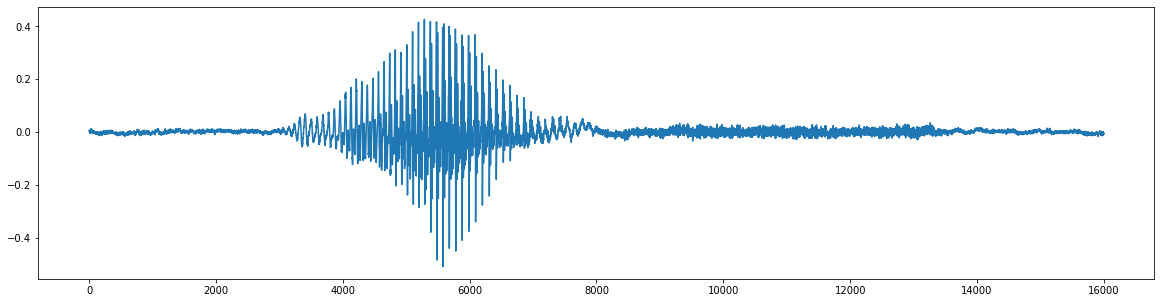

In [11]:
plt.figure(figsize=(20,5))
plt.plot(audios[7])

In [12]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melmodel = Sequential()

melmodel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
                         padding='same', sr=sr, n_mels=100,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='Mel_Short_time_Fourier_Transform') )

melmodel.add(Normalization2D(int_axis=0))
melmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Mel_Short_time_Fourier_Trans (None, 100, 125, 1)       1101924   
_________________________________________________________________
normalization2d (Normalizati (None, 100, 125, 1)       0         
Total params: 1,101,924
Trainable params: 1,101,924
Non-trainable params: 0
_________________________________________________________________


In [13]:
mel_spec = melmodel.predict( audios.reshape((-1,1,input_len)) )
#mel_spec.shape #(batch_size, melDim, timeSteps, 1)
print("Batch size: ",mel_spec.shape[0] )
print("Mel Values: ",mel_spec.shape[1] )
print("Samples: ",mel_spec.shape[2] )

Batch size:  32
Mel Values:  100
Samples:  125


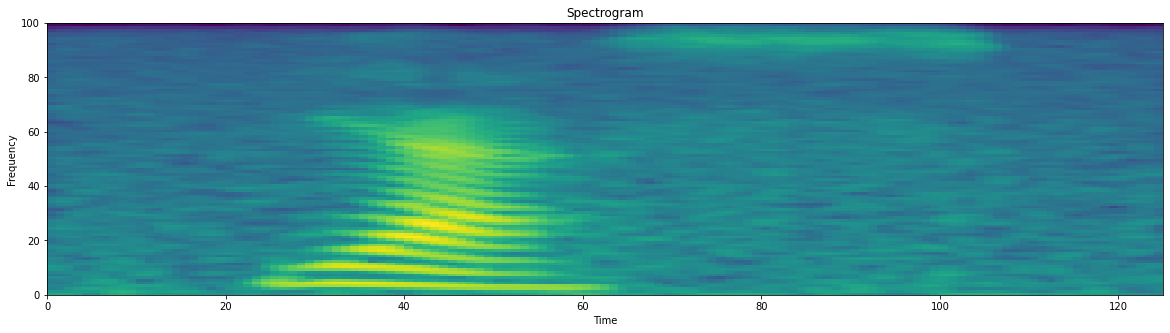

In [14]:
plt.figure(figsize=(20,5))
plt.pcolormesh(mel_spec[7,:,:,0])
plt.title('Spectrogram')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

In [15]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
from tensorflow.keras import layers as L
from tensorflow.keras import optimizers


def speech_model(nCategories):
    sr = 16000
    input_len = 16000

    inputs = L.Input((input_len,), name='Input')

    x = L.Reshape((1, -1))(inputs)

    mspec = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='Mel_Short_time_Fourier_Transform')
    mspec.trainable = False

    x = mspec(x)

    x = Normalization2D(int_axis=0, name='2D_Normalizer')(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x) #(timestep, meldim, 1)

    x = L.Conv2D(8, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)

    x = L.Lambda(lambda q: K.squeeze(q, -1), name='Squeeze')(x)

    x = L.Bidirectional(L.LSTM(128, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(256)(xFirst)
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='softmax_on_attn')(attScores)  # [b_s, seq_len]
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]
    
    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(64)(x)
    output = L.Dense(nCategories, activation='softmax', name='Output_layer')(x)
    model = Model(inputs=[inputs], outputs=[output])
    return model

In [16]:
from tensorflow.keras.models import Model, load_model
from keras import layers as L

model = speech_model(num_catgs)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 16000)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 16000)     0           Input[0][0]                      
__________________________________________________________________________________________________
Mel_Short_time_Fourier_Transfor (None, 80, 125, 1)   1091664     reshape[0][0]                    
__________________________________________________________________________________________________
2D_Normalizer (Normalization2D) (None, 80, 125, 1)   0           Mel_Short_time_Fourier_Transform[
______________________________________________________________________________________________

In [17]:
#model.load_weights('/content/drive/MyDrive/SamsungPrismVMAR/speechmodel_data.h5')

In [18]:
#!cp "/content/speechmodel_data.h5" -r "/content/drive/MyDrive/SamsungPrismVMAR/attRNNModel"

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-speechmodel_data.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=25, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer])

model.save('speechmodel_data.h5')

Epoch 1/25
2651/2651 - 189s - loss: 0.8731 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.4496 - val_sparse_categorical_accuracy: 0.8751

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.87510, saving model to model-speechmodel_data.h5
Epoch 2/25
2651/2651 - 178s - loss: 0.3984 - sparse_categorical_accuracy: 0.8888 - val_loss: 0.3711 - val_sparse_categorical_accuracy: 0.8965

Epoch 00002: val_sparse_categorical_accuracy improved from 0.87510 to 0.89650, saving model to model-speechmodel_data.h5
Epoch 3/25
2651/2651 - 171s - loss: 0.3271 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.2968 - val_sparse_categorical_accuracy: 0.9187

Epoch 00003: val_sparse_categorical_accuracy improved from 0.89650 to 0.91871, saving model to model-speechmodel_data.h5
Epoch 4/25
2651/2651 - 170s - loss: 0.2679 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.2786 - val_sparse_categorical_accuracy: 0.9224

Epoch 00004: val_sparse_categorical_accuracy improved from 0.91871 t

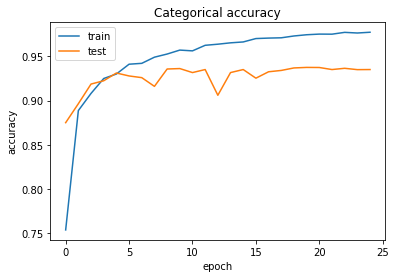

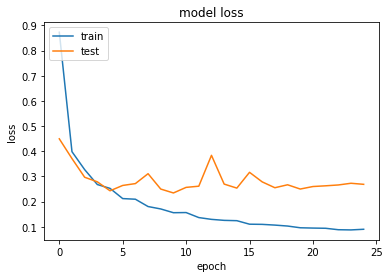

In [20]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
!cp "/content/speechmodel_data.h5" -r "/content/drive/MyDrive/SamsungPrismVMAR/Speechmodel"

In [23]:
# load best model according to cross-validation - speechmodel_data
model = load_model('speechmodel_data.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('speechmodel_data.h5')

In [24]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [25]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.09930413216352463, 0.9735713005065918] 
Validation: [0.2746460437774658, 0.9343850612640381] 
Test: [0.2912901043891907, 0.9293957352638245]


In [26]:
Speechmodel_implement = Model(inputs=model.input,
                                 outputs=[model.get_layer('Output_layer').output, 
                                          model.get_layer('softmax_on_attn').output,
                                          model.get_layer('Mel_Short_time_Fourier_Transform').output])

In [27]:
audios, classes = valGen.__getitem__(5)
classes

array([ 3, 25, 23,  7, 23, 34,  6, 19,  5,  8, 35, 13, 13,  7, 20,  1, 11,
       19, 10, 25, 22, 19,  5,  6, 26, 25, 12, 13, 12, 29,  8, 13])

In [28]:
outs, attW, specs = Speechmodel_implement.predict(audios)

In [29]:
print(outs)

[[4.42021086e-09 1.37969440e-08 6.00979058e-03 ... 2.13751093e-07
  6.48624654e-10 3.39571420e-06]
 [1.03681215e-08 3.46296880e-10 2.51239203e-11 ... 3.12413123e-10
  1.83618418e-08 7.17160662e-12]
 [5.64808963e-11 2.83422757e-10 1.64698713e-10 ... 1.24192532e-08
  2.32146680e-11 4.67011065e-12]
 ...
 [9.14130160e-11 2.06286171e-15 1.45132161e-11 ... 1.16859898e-11
  2.51996202e-11 8.78236340e-13]
 [8.86400259e-11 7.58874574e-10 1.14408705e-10 ... 3.35209277e-10
  2.55031152e-11 9.20642174e-11]
 [1.09311317e-10 8.99234010e-07 2.17348713e-07 ... 2.08693751e-09
  1.61372569e-08 1.21994875e-03]]


In [30]:
np.argmax(outs,axis=1)

array([ 3, 25, 23,  7, 23, 34,  6, 19,  5,  8, 35, 13, 13,  7, 20,  1, 11,
       19, 10,  5, 22, 27,  5,  6, 26, 25, 12, 13, 12, 29,  8, 13])

In [31]:
specs.shape

(32, 80, 125, 1)

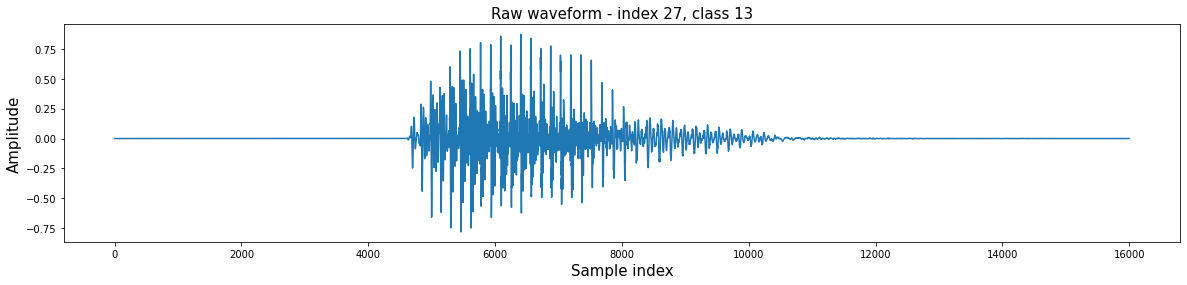

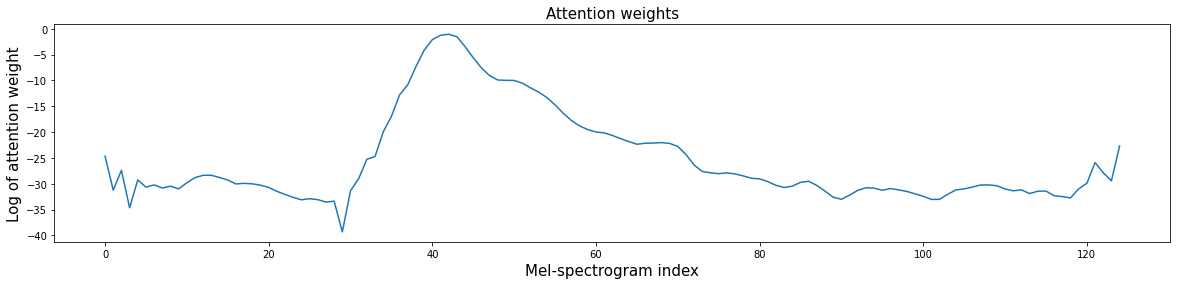

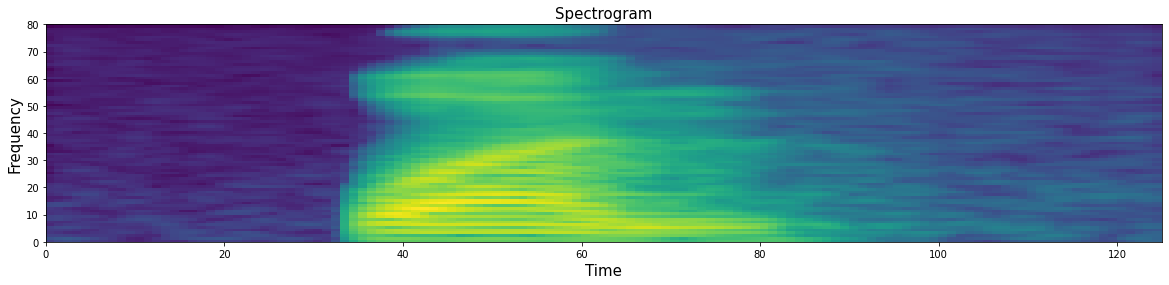

In [38]:
idAudio=27
plt.figure(figsize=(20,4))
plt.title('Raw waveform - index 27, class 13', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Sample index', fontsize=15)
plt.plot(audios[idAudio])
plt.savefig('audio_3.png', dpi = 400)
plt.show()

plt.figure(figsize=(20,4))
plt.title('Attention weights', fontsize=15)
plt.ylabel('Log of attention weight', fontsize=15)
plt.xlabel('Mel-spectrogram index', fontsize=15)
plt.plot(np.log(attW[idAudio]))
plt.savefig('attn_3.png', dpi = 400)
plt.show()


plt.figure(figsize=(20,4))
plt.pcolormesh(specs[idAudio,:,:,0])
plt.title('Spectrogram', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.savefig('melgraph_3.png', dpi = 400)
plt.show()

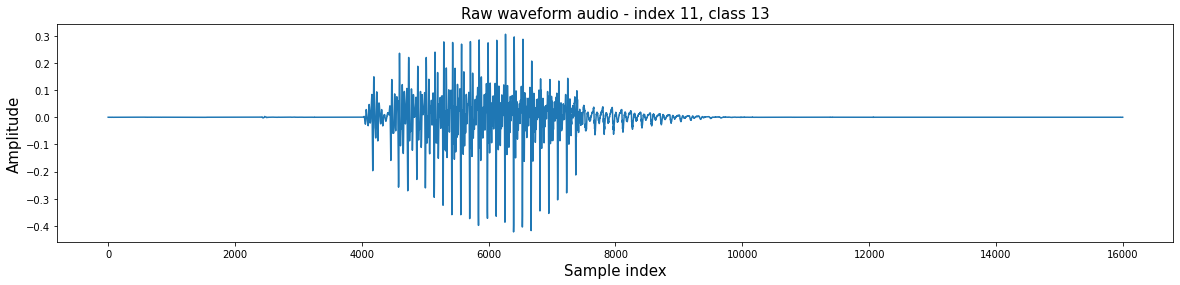

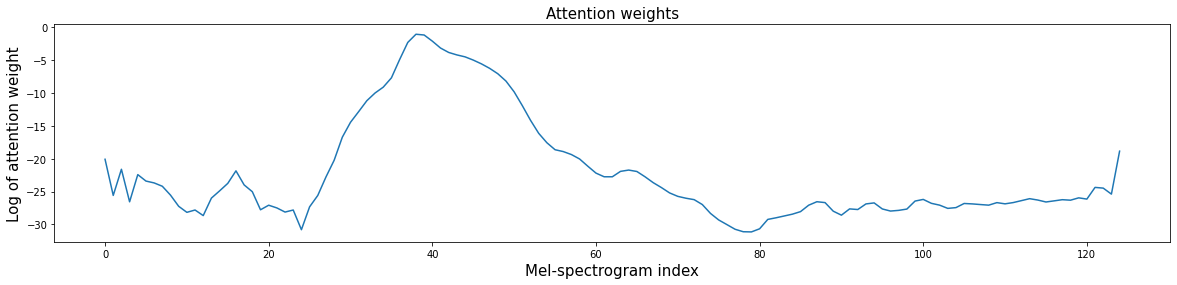

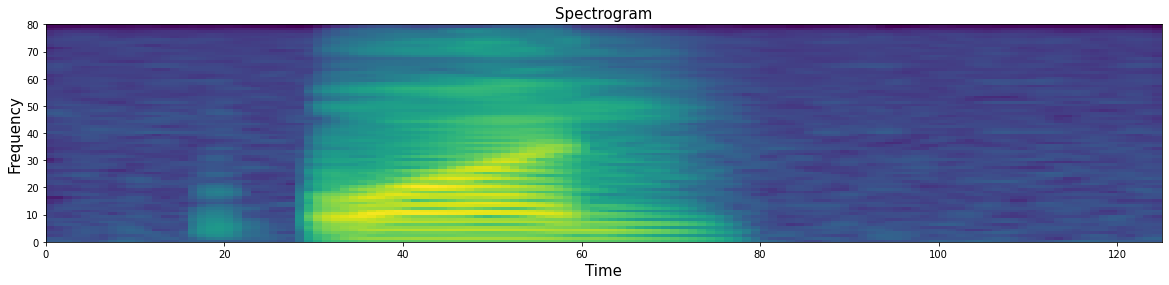

In [39]:
idAudio=11
plt.figure(figsize=(20,4))
plt.title('Raw waveform audio - index 11, class 13', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Sample index', fontsize=15)
plt.plot(audios[idAudio])
plt.savefig('audio_1.png', dpi = 400)
plt.show()

plt.figure(figsize=(20,4))
plt.title('Attention weights', fontsize=15)
plt.ylabel('Log of attention weight', fontsize=15)
plt.xlabel('Mel-spectrogram index', fontsize=15)
plt.plot(np.log(attW[idAudio]))
plt.savefig('attn_1.png', dpi = 400)
plt.show()


plt.figure(figsize=(20,4))
plt.pcolormesh(specs[idAudio,:,:,0])
plt.title('Spectrogram', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.savefig('melgraph_1.png', dpi = 400)

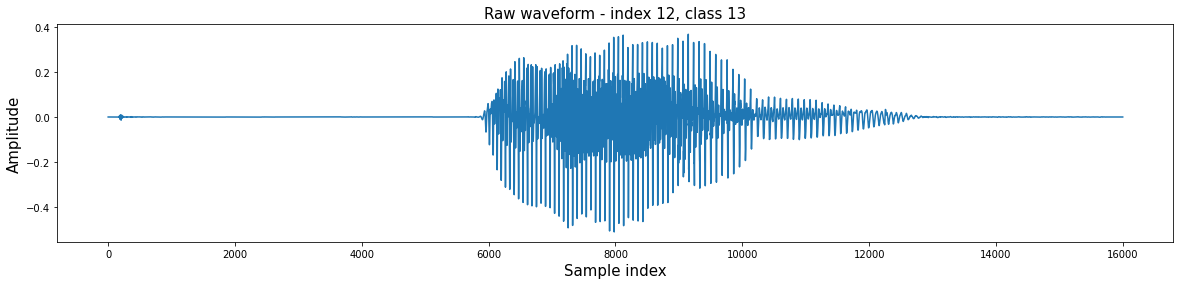

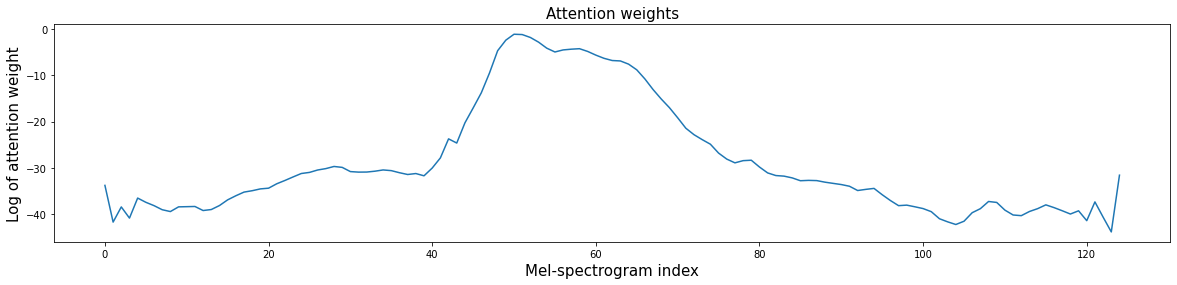

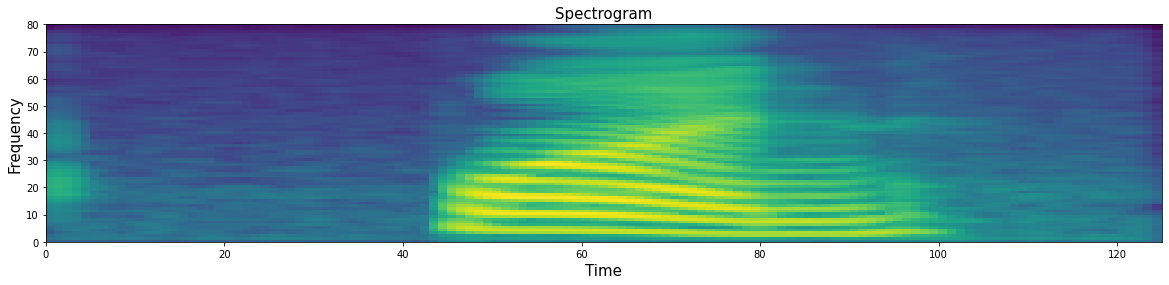

In [40]:
idAudio=12
plt.figure(figsize=(20,4))
plt.title('Raw waveform - index 12, class 13', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Sample index', fontsize=15)
plt.plot(audios[idAudio])
plt.savefig('audio_2.png', dpi = 400)
plt.show()

plt.figure(figsize=(20,4))
plt.title('Attention weights', fontsize=15)
plt.ylabel('Log of attention weight', fontsize=15)
plt.xlabel('Mel-spectrogram index', fontsize=15)
plt.plot(np.log(attW[idAudio]))
plt.savefig('attn_2.png', dpi = 400)
plt.show()


plt.figure(figsize=(20,4))
plt.pcolormesh(specs[idAudio,:,:,0])
plt.title('Spectrogram', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.savefig('melgraph_2.png', dpi = 400)

In [41]:
y_pred = model.predict(x_test)

In [42]:
y_pred.shape

(11005, 36)

In [43]:
y_test.shape

(11005,)

In [44]:
y_test

array([ 7,  7,  7, ..., 16, 16, 16])

In [46]:
y_hat=np.argmax(y_pred,axis=1)

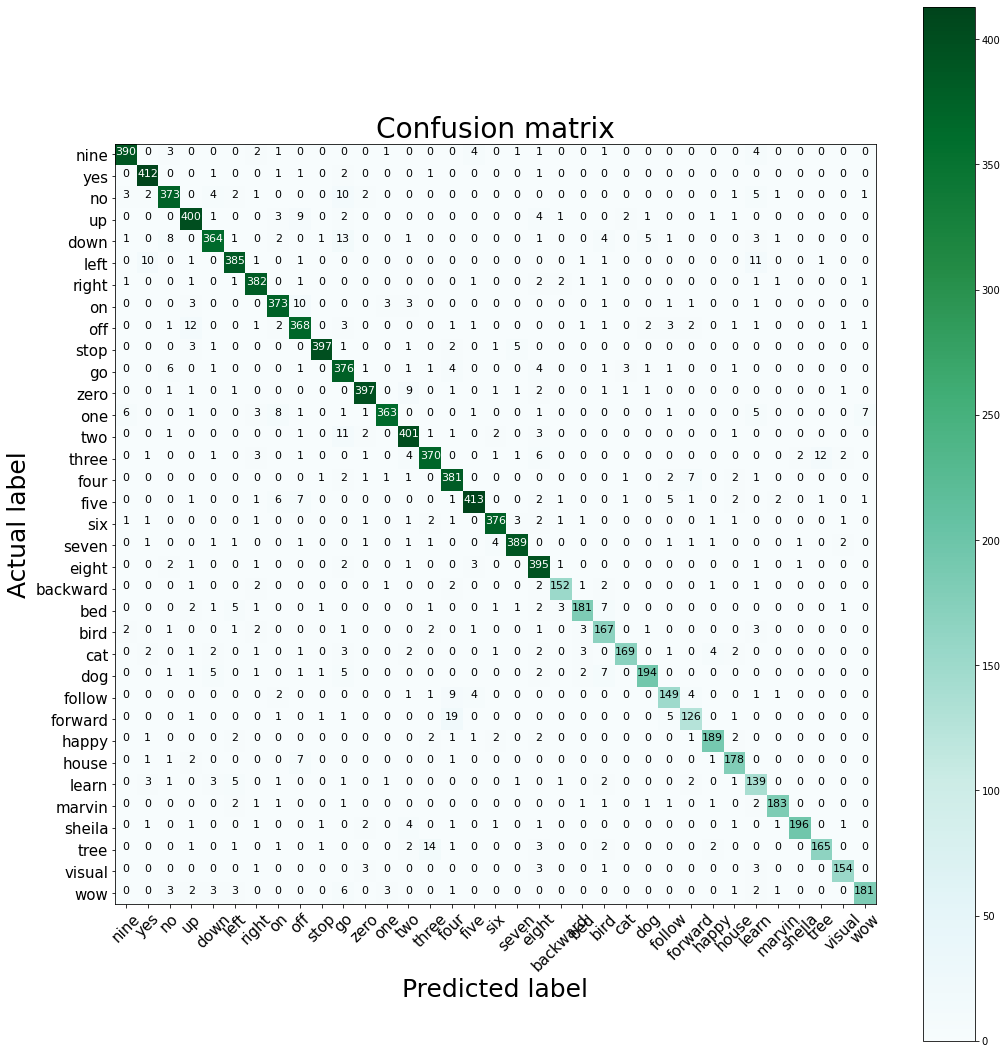

In [101]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

plt.figure(figsize=(15, 15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title('Confusion matrix', fontsize=28)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
plt.yticks(tick_marks, classes, fontsize=15)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), size=11,
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual label', fontsize=25)
plt.xlabel('Predicted label', fontsize=25)
plt.savefig('ConfusionMatrix_enlarged.png', dpi=400)
plt.tight_layout()

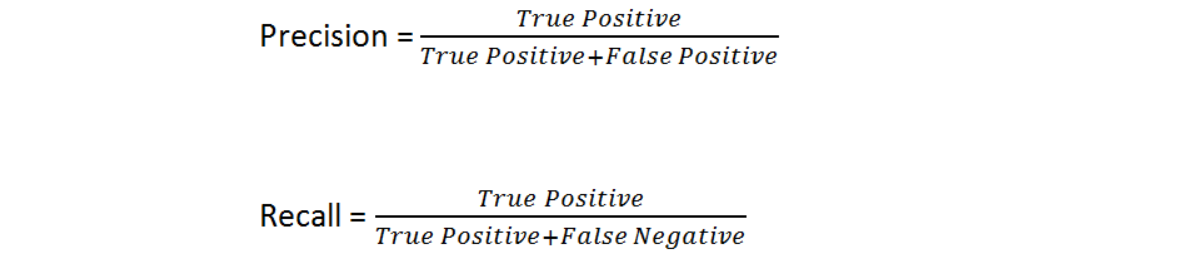

In [61]:
recall = np.diag(cm) / np.sum(cm, axis = 1) #Recall is a good measure to determine, when there is a high cost associated with False Negative.
precision = np.diag(cm) / np.sum(cm, axis = 0) #Precision is a good measure to determine, when the costs of False Positive is high

mean_recall=np.mean(recall) #(TP/(TP+FN))
mean_precision=np.mean(precision) #TP/(TP+FP)
F1_score = (2*mean_recall*mean_precision)/(mean_precision+mean_recall) #balance between recall and precision

print("Mean Recall: ",mean_recall)
print("Mean Precision: ",mean_precision)
print("F1 Score: ",F1_score)

Mean Recall:  0.9206372551498896
Mean Precision:  0.925759923020486
F1 Score:  0.9231914828876636


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


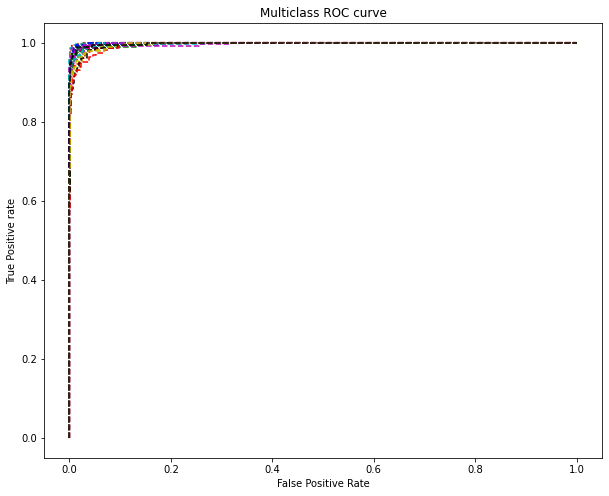

In [95]:
# roc curve for classes
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statistics
fpr = {}
tpr = {}
thresh ={}

n_class = 35
colourr=['b','g','r','c','m','y','k','b','g','r','c','m','y','k','b','g','r','c','m','y','k','b','g','r','c','m','y','k','b','g','r','c','m','y','k']

plt.figure(figsize=(10, 8))
for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colourr[i], label='Class'+str(i)+''+'vs Rest')
    
    
    
# plotting    
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
#plt.legend(loc='best')
plt.savefig('Multiclass_ROC',dpi=300)

In [77]:
#model = SpeechModels.speech_model(num_catgs)
#model.load_weights('speechmodel_data.h5')

model = load_model('speechmodel_data.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [79]:
import os
#os.listdir('SpeechModel_Final_dir/')

# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
  
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
!pip install -r /content/drive/MyDrive/SamsungPrismVMAR/requirements.txt
import tensorflow.keras
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

In [ ]:
wkdir = '/content/drive/MyDrive/SamsungPrismVMAR'
pb_filename = 'SpeechModel_Final.pb'
import tensorflow as tf
# save keras model as tf pb files ===============
sess = tf.compat.v1.keras.backend.get_session()

frozen_graph = freeze_session(sess,output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)

In [102]:
!cp -r /content/model-speechmodel_data.h5 /content/drive/MyDrive/SamsungPrismVMAR
!cp -r /content/speechmodel_data.h5 /content/drive/MyDrive/SamsungPrismVMAR
!cp -r /content/ConfusionMatrix_enlarged.png /content/drive/MyDrive/SamsungPrismVMAR
!cp -r /content/Multiclass_ROC.png /content/drive/MyDrive/SamsungPrismVMAR
#!cp -r /content/attRNNModel /content/drive/MyDrive/SamsungPrismVMAR/
#!cp -r /content/sd_GSCmdV2.zip /content/drive/MyDrive

In [103]:
!cp -r /content/attn_1.png /content/drive/MyDrive/SamsungPrismVMAR
!cp -r /content/audio_1.png /content/drive/MyDrive/SamsungPrismVMAR
!cp -r /content/melgraph_1.png /content/drive/MyDrive/SamsungPrismVMAR
#!cp -r /content/Multiclass_ROC.png /content/drive/MyDrive/SamsungPrismVMAR